# A peek into autoencoders

### 1. Autoencoder

An autoencoder is a type of neural network that tries to learn parameters that make the output as close to the input as possible. It contains a small hidden layer! If that hidden layer has a smaller dimension than the input, the hidden layer is a compression of your data, called encoding. The process of reconstructing the input from the hidden layer is called
decoding.

TIP: Generally with neural networks, adding more hidden layers seems to improve performance if you have
enough data to not overfit the model.

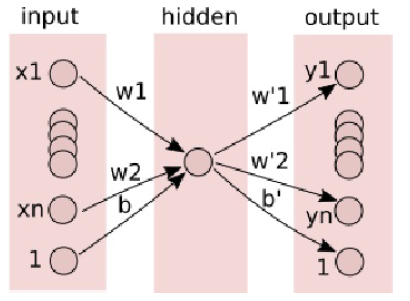

In [2]:
import tensorflow as tf
import numpy as np

'''
Training a network one-by-one is the safest bet if you’re not pressured with time. But if your network is taking longer than desired, one solution is to train it with multiple data inputs at a
time, called batch training.
Typically, as the batch size increases, the algorithm speeds up, but has less guarantees of successful convergence.
'''
def get_batch(X, size):
    a = np.random.choice(len(X), size, replace=False)
    return X[a]

class Autoencoder:
    def __init__(self, input_dim, hidden_dim, epoch=500, batch_size=10, learning_rate=0.001):

        # Define input layer of neural network
        x = tf.placeholder(dtype=tf.float32, shape=[None, input_dim])
        
        # Define variables
        with tf.name_scope('encode'):
            weights = tf.Variable(tf.random_normal([input_dim, hidden_dim], dtype=tf.float32), name='weights')
            biases = tf.Variable(tf.zeros([hidden_dim]), name='biases')
            encoded = tf.nn.sigmoid(tf.matmul(x, weights) + biases)
        with tf.name_scope('decode'):
            weights = tf.Variable(tf.random_normal([hidden_dim, input_dim], dtype=tf.float32), name='weights')
            biases = tf.Variable(tf.zeros([input_dim]), name='biases')
            decoded = tf.matmul(encoded, weights) + biases

        # Define class variables
        self.x = x                                          # input layer of neural network
        self.epoch = epoch                                  # Number of learning cycles
        self.batch_size = batch_size                        # number of training example to train in parellel
        self.learning_rate = learning_rate                  # Hyper-parameter of optimizer
        self.encoded = encoded
        self.decoded = decoded
        
        # Reconstruction Cost
        self.loss = tf.sqrt(tf.reduce_mean(tf.square(tf.subtract(self.x, self.decoded))))
        
        # Choose an optimizer
        self.train_op = tf.train.AdamOptimizer(self.learning_rate).minimize(self.loss)
        
        # Define a saver op
        self.saver = tf.train.Saver()

    def train(self, data):
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            
            #loop through all training examples
            for i in range(self.epoch):
                
                # Loop through various batch selections and run the optimizer on a randomly selected batch
                for j in range(500):
                    batch_data = get_batch(data, self.batch_size)
                    l, _ = sess.run([self.loss, self.train_op], feed_dict={self.x: batch_data})
                
                # Print the reconstruction error once every 50 cycles
                if i % 50 == 0:
                    print('epoch {0}: loss = {1}'.format(i, l))
                    self.saver.save(sess, './model.ckpt')
            
            # Save the learned parameters to file
            self.saver.save(sess, './model.ckpt')
        
    def test(self, data):
        with tf.Session() as sess:
            # Load the learned parameters
            self.saver.restore(sess, './model.ckpt')
             
            # Reconstruct the input
            hidden, reconstructed = sess.run([self.encoded, self.decoded], feed_dict={self.x: data})
        
        print('input', data)
        print('compressed', hidden)
        print('reconstructed', reconstructed)
        return reconstructed


from sklearn import datasets
hidden_dim = 1
data = datasets.load_iris().data
input_dim = len(data[0])
ae = Autoencoder(input_dim, hidden_dim)
ae.train(data)
ae.test([[8, 4, 6, 2]])

epoch 0: loss = 3.3993327617645264
epoch 50: loss = 0.30947524309158325
epoch 100: loss = 0.2593497037887573
epoch 150: loss = 0.29320472478866577
epoch 200: loss = 0.24477973580360413
epoch 250: loss = 0.21314585208892822
epoch 300: loss = 0.3992544412612915
epoch 350: loss = 0.35435643792152405
epoch 400: loss = 0.28602781891822815
epoch 450: loss = 0.30234816670417786
INFO:tensorflow:Restoring parameters from ./model.ckpt
input [[8, 4, 6, 2]]
compressed [[ 0.72182214]]
reconstructed [[ 6.88460064  2.80477047  6.21680355  2.21607113]]


array([[ 6.88460064,  2.80477047,  6.21680355,  2.21607113]], dtype=float32)

### 2. Autoencoder with images

In [5]:
%matplotlib inline
from matplotlib import pyplot as plt
import pickle
import numpy as np

# Reading from extracted CIFAR-10 dataset
def unpickle(file):
    fo = open(file, 'rb')
    dict = pickle.load(fo, encoding='latin1')
    fo.close()
    return dict

# Convert to greyscale and 1 dimentional vector
def grayscale(a):
    return a.reshape(a.shape[0], 3, 32, 32).mean(1).reshape(a.shape[0], -1)


names = unpickle('./cifar-10-batches-py/batches.meta')['label_names']
data, labels = [], []
for i in range(1, 6):
    filename = './cifar-10-batches-py/data_batch_' + str(i)
    batch_data = unpickle(filename)
    if len(data) > 0:
        data = np.vstack((data, batch_data['data']))
        labels = np.hstack((labels, batch_data['labels']))
    else:
        data = batch_data['data']
        labels = batch_data['labels']

data = grayscale(data)
x = np.matrix(data)
y = np.array(labels)

horse_indices = np.where(y == 7)[0]
horse_x = x[horse_indices]
print(np.shape(horse_x))  # (5000, 3072)

print('Some examples of horse images we will feed to the autoencoder for training')
plt.rcParams['figure.figsize'] = (10, 10)
num_examples = 5
for i in range(num_examples):
    horse_img = np.reshape(horse_x[i, :], (32, 32))
    plt.subplot(1, num_examples, i+1)
    plt.imshow(horse_img, cmap='Greys_r')
plt.show()

test_data = unpickle('./cifar-10-batches-py/test_batch')
test_x = grayscale(test_data['data'])
test_labels = np.array(test_data['labels'])
encodings = ae.classify(test_x, test_labels)

plt.rcParams['figure.figsize'] = (100, 100)
plt.figure()
for i in range(20):
    plt.subplot(20, 2, i*2 + 1)
    original_img = np.reshape(test_x[i, :], (32, 32))
    plt.imshow(original_img, cmap='Greys_r')
    
    plt.subplot(20, 2, i*2 + 2)
    reconstructed_img = ae.decode([encodings[i]])
    plt.imshow(reconstructed_img, cmap='Greys_r')

plt.show()

FileNotFoundError: [Errno 2] No such file or directory: './cifar-10-batches-py/batches.meta'